## *Learning CBF Example: Two Airplanes Collision Avoidance*

## Part 0: Problem Statement
States: 
$$ \textbf{x}=\left[\begin{array}{lll}{p_{x,a}} & {p_{y,a}} & {\theta_{a}} & {p_{x,b}} & {p_{y,b}} & {\theta_{b}} \end{array}\right]^{\top} 
$$
Controls: 
$$ \textbf{u}=\left[\begin{array}{lll}{v_{a}} & {\omega_{a}} & {v_{b}} & {\omega_{b}} \end{array}\right]^{\top}
$$
System dynamics: $$
\dot{\mathbf{x}}(t)=\left[\begin{array}{c}{v_{a}(t) \cos \left(\theta_{a}(t)\right)} \\ {v_{a}(t) \sin \left(\theta_{a}(t)\right)} \\ {\omega_{a}(t)} \\ {v_{b}(t) \cos \left(\theta_{b}(t)\right)} \\ {v_{b}(t) \sin \left(\theta_{b}(t)\right)} \\ {\omega_{b}(t)}\end{array}\right]
$$
Geometric safe set:
$$
\mathcal{S}:=\left\{\mathbf{x}:\left(p_{x,a}(t)-p_{x,b}(t)\right)^{2}+\left(p_{y,a}(t)-p_{y,b}(t)\right)^{2}-D_{s}^{2} \geq 0\right\}, \quad D_s = 0.5
$$

## Part 1: Data Generation

In [ ]:
# Install JAX, CasADi and IPOPT
!apt install coinor-libipopt-dev
!pip install ipopt
!pip install casadi
# !pip install jaxlib==0.1.56+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html
# !pip uninstall jax
# !pip install jax==0.2.4

!pip install jax==0.3.0 jaxlib==0.3.0

In [ ]:
from casadi import *
import jax.numpy as jnp
import jax
import numpy as onp
import matplotlib.pylab as plt
from jax import random, vmap, jit, grad, ops, lax, tree_util, device_put, device_get
from jax.flatten_util import ravel_pytree
# from jax.experimental import optimizers
from jax.example_libraries import optimizerss
from functools import partial
import time

In [ ]:
def ODE_RHS(x, u):
  # RHS of the aircraft dynamics
  xdot = [
      u[0] * onp.cos(x[2]), u[0] * onp.sin(x[2]), u[1], u[2] * onp.cos(x[5]), u[2] * onp.sin(x[5]),
      u[3]
  ]
  return onp.array(xdot)


def dynamics_RK4(x, u, T, N):
  # RK4 integrator
  M = 4  # RK4 steps per interval
  DT = T / N / M
  X = onp.array(x)
  U = onp.array(u)
  for j in range(M):
    k1 = ODE_RHS(X, U)
    k2 = ODE_RHS(X + DT/2*k1, U)
    k3 = ODE_RHS(X + DT/2*k2, U)
    k4 = ODE_RHS(X + DT*k3, U)
    X = X + DT / 6 * (k1 + 2*k2 + 2*k3 + k4)
  return list(X)


def ZCBF(x):
  # The constructive CBF in [Squires et al]
  A1 = db(x)**2 + dc(x)**2 + 2 * (v / w)**2 - 2 * ((v / w)**2) * onp.cos(x[2] - x[5])
  A2 = compute_A2(x)
  h = A1 - A2 - Ds**2
  return h


def num_grad(x):
  # Numerically compute the gradient of CBF h(x) w.r.t. x
  eps_grad = 1e-10
  dhdx = []
  for i in range(x.size):
    Eps = 0 * x
    Eps[i] = eps_grad
    dhdx.append((ZCBF(x + Eps) - ZCBF(x - Eps)) / (2*eps_grad))
  return dhdx  # return a list


def generate_init_condition(R, num_points):
  # Generate initial conditions on a circle with radius R
  angle_vec = onp.linspace(0, 2 * onp.pi, num=num_points)
  X_start = []
  X_goal = []
  for angle in angle_vec:
    temp = R * onp.exp(angle * 1j)
    x_start = [temp.real, temp.imag, onp.pi + angle, -temp.real, -temp.imag, angle]
    if use_human_data:
      if temp.real >= 0:
        x_goal = [-2000, 0, onp.pi, 2000, 0, 0]
      else:
        x_goal = [2000, 0, 0, -2000, 0, onp.pi]
    else:
      if temp.real >= 0:
        x_goal = [-5, 0, onp.pi, 5, 0, 0]
      else:
        x_goal = [5, 0, 0, -5, 0, onp.pi]
    X_start.append(x_start)
    X_goal.append(x_goal)
  return onp.array(X_start), onp.array(X_goal)


def generate_training_data(X_start, X_goal, N_sim):
  # Generate expert demonstrations
  X_train = []
  U_train = []
  for i in range(X_start[:, 1].size):
    Xcl, Ucl, _ = safe_closed_loop(
        list(X_start[i, :]), list(X_goal[i, :]), N_sim, learning=0, plot=0, early_stop=1
    )
    X_train.append(Xcl[:-1, :])
    U_train.append(Ucl)
  X_train = onp.array(X_train)
  U_train = onp.array(U_train)
  return X_train, U_train


def get_ring_data(X, U, R_lb, R_ub, verbose):
  # Obtain the data within the ring of inner radius R_lb and outer radius R_ub
  X_out = []
  U_out = []
  for i in range(X.shape[0]):
    if R_lb <= onp.sqrt((X[i, 0] - X[i, 3])**2 + (X[i, 1] - X[i, 4])**2) <= R_ub:
      X_out.append(X[i, :])
      if U is not None:
        U_out.append(U[i, :])
  X_out = onp.array(X_out)
  U_out = onp.array(U_out)
  if verbose:
    print(X_out.shape[0], 'points selected out from', X.shape[0], 'given points')
  return X_out, U_out


def safe_closed_loop(x_init, x_goal, N_sim, learning, plot, early_stop):
  # Closed-loop Simulations with CBF+MPC
  Xcl = []
  Ucl = []
  Xcl.append(onp.array(x_init))
  xt = x_init
  sep_min = onp.sqrt((x_init[0] - x_init[3])**2 + (x_init[1] - x_init[4])**2)
  count = 0
  for t in range(N_sim):
    u_opt = CFTOC_NMPC(xt, x_goal, T, N)  # Solve the NMPC problem at the current time
    u_mod, f_mod = CBF_QP(xt, u_opt, learning)  # Solve the CBF-QP problem at the current time
    if onp.linalg.norm(onp.array(u_opt) - onp.array(u_mod)) <= 0.1:
      count += 1
    sep_now = onp.sqrt((xt[0] - xt[3])**2 + (xt[1] - xt[4])**2)
    # (optional) disengage the CBF in the interior of the safe set
    if use_human_data:
      if sep_now >= 1.2 * Ds:
        u_mod = u_opt
    if sep_now < sep_min:
      sep_min = sep_now
    if early_stop and count >= 5:
      break
    xt = dynamics_RK4(xt, u_mod, T, N)  # Evolve the system
    Xcl.append(onp.array(xt))
    Ucl.append(onp.array(u_mod))
  Xcl = onp.array(Xcl)
  Ucl = onp.array(Ucl)
  if plot:
    tgrid = [ts * k for k in range(N_sim)]
    plt.figure(figsize=(10, 5))
    plt.clf()
    plt.plot(Xcl[:, 0], Xcl[:, 1], '-')
    plt.plot(Xcl[:, 3], Xcl[:, 4], '-')
    plt.xlabel('$p_x$')
    plt.ylabel('$p_y$')
    plt.legend(['agent a', 'agent b'])
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.axis('equal')
    plt.grid()
    # plt.savefig('closed_loop_plane.pdf', dpi=300)
    plt.figure()
    plt.clf()
    plt.step(tgrid, Ucl[:, 0], '-.')
    plt.step(tgrid, Ucl[:, 1], '-.')
    plt.step(tgrid, Ucl[:, 2], '-.')
    plt.step(tgrid, Ucl[:, 3], '-.')
    plt.xlabel('t')
    plt.legend(['u1', 'u2', 'u3', 'u4'])
    plt.grid()
    plt.show()
  return Xcl, Ucl, sep_min


def plot_closed_loop(Xcl, Ucl, timesteps):
  # Plot closed-loop state and input trajectories
  for t in timesteps:
    tgrid = [ts * k for k in range(t)]
    plt.figure()
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.plot(Xcl[:t, 0], Xcl[:t, 1], '-')
    plt.plot(Xcl[:t, 3], Xcl[:t, 4], '-')
    plt.xlabel('x')
    plt.legend(['agent a', 'agent b'])
    plt.grid()
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.subplot(1, 2, 2)
    plt.step(tgrid, Ucl[:t, 0], '-.')
    plt.step(tgrid, Ucl[:t, 1], '-.')
    plt.step(tgrid, Ucl[:t, 2], '-.')
    plt.step(tgrid, Ucl[:t, 3], '-.')
    plt.xlabel('t')
    plt.legend(['u1', 'u2', 'u3', 'u4'])
    plt.grid()
    plt.show()


def CBF_QP(x, u_opt, learning):
  # Solve the CBF-QP problem
  x = onp.array(x)  # Current states
  u1 = SX.sym('u1')  # Decision variables
  u2 = SX.sym('u2')
  u3 = SX.sym('u3')
  u4 = SX.sym('u4')
  u = vertcat(u1, u2, u3, u4)
  V = (u1 - u_opt[0])**2 + (u2 - u_opt[1])**2 + (u3 - u_opt[2]
                                                )**2 + (u4 - u_opt[3])**2  # Objective function
  lbu = u_lb  # Variable bounds
  ubu = u_ub
  if learning:
    hx = h_model(x, params)
    dhdx = grad(h_model, argnums=0)(x, params)
  else:
    hx = ZCBF(x)
    dhdx = num_grad(x)
  g = [ dhdx[0]*(u1*onp.cos(x[2])) + dhdx[1]*(u1*onp.sin(x[2])) + dhdx[2]*u2 + \
        dhdx[3]*(u3*onp.cos(x[5])) + dhdx[4]*(u3*onp.sin(x[5])) + dhdx[5]*u4 + hx**3 ] # LHS of the CBF constraint
  lbg = [0]  # Constraint bounds
  ubg = [inf]
  qp = {'x': u, 'f': V, 'g': vertcat(*g)}  # Formulate the QP
  solver = qpsol('solver', 'qpoases', qp, {'sparse': True, 'error_on_fail': False})  # Solve the QP
  sol = solver(lbx=lbu, ubx=ubu, lbg=lbg, ubg=ubg)  # Get the optimal solution
  u_mod = sol['x'].full().flatten()
  f_opt = sol['f'].full().flatten()
  return list(u_mod), list(f_opt)


def CFTOC_NMPC(x_init, x_goal, T, N):
  # Solve the NMPC problem
  nx = 6
  nu = 4
  x1 = MX.sym('x1')  # Declare model variables
  x2 = MX.sym('x2')
  x3 = MX.sym('x3')
  x4 = MX.sym('x4')
  x5 = MX.sym('x5')
  x6 = MX.sym('x6')
  u1 = MX.sym('u1')
  u2 = MX.sym('u2')
  u3 = MX.sym('u3')
  u4 = MX.sym('u4')
  x = vertcat(x1, x2, x3, x4, x5, x6)
  u = vertcat(u1, u2, u3, u4)
  xdot = vertcat(u1 * cos(x3), u1 * sin(x3), u2, u3 * cos(x6), u3 * sin(x6), u4)  # Model equations
  if use_human_data:
    L = 5*(x1-x_goal[0])**2 + 15*(x2-x_goal[1])**2 + 1*(x3-x_goal[2])**2 + \
        5*(x4-x_goal[3])**2 + 15*(x5-x_goal[4])**2 + 1*(x6-x_goal[5])**2 + \
        1*u1**2 + 0.1*u2**2 + 1*u3**2 + 0.1*u4**2 # Objective term
  else:
    L = 5*(x1-x_goal[0])**2 + 2*(x2-x_goal[1])**2 + 1*(x3-x_goal[2])**2 + \
        5*(x4-x_goal[3])**2 + 2*(x5-x_goal[4])**2 + 1*(x6-x_goal[5])**2 + \
        1*u1**2 + 0.1*u2**2 + 1*u3**2 + 0.1*u4**2 # Objective term
  # Formulate discrete time dynamics using fixed step Runge-Kutta 4 integrator
  M = 4  # RK4 steps per interval
  DT = T / N / M
  f = Function('f', [x, u], [xdot, L])
  X0 = MX.sym('X0', nx)
  U = MX.sym('U', nu)
  X = X0
  Q = 0
  for j in range(M):
    k1, k1_q = f(X, U)
    k2, k2_q = f(X + DT/2*k1, U)
    k3, k3_q = f(X + DT/2*k2, U)
    k4, k4_q = f(X + DT*k3, U)
    X = X + DT / 6 * (k1 + 2*k2 + 2*k3 + k4)
    Q = Q + DT / 6 * (k1_q + 2*k2_q + 2*k3_q + k4_q)
  F = Function('F', [X0, U], [X, Q], ['x0', 'p'], ['xf', 'qf'])
  # Start with an empty NLP
  w = []
  w0 = []
  lbw = []
  ubw = []
  J = 0
  g = []
  lbg = []
  ubg = []
  # "Lift" initial conditions
  Xk = MX.sym('X0', nx)
  w += [Xk]
  lbw += x_init
  ubw += x_init
  w0 += x_init
  # Formulate the NLP
  for k in range(N):
    Uk = MX.sym('U_' + str(k), nu)  # New NLP variable for the control
    w += [Uk]
    lbw += u_lb
    ubw += u_ub
    w0 += [0, 0, 0, 0]
    Fk = F(x0=Xk, p=Uk)  # Integrate till the end of the interval
    Xk_end = Fk['xf']
    J = J + Fk['qf']
    Xk = MX.sym('X_' + str(k + 1), nx)  # New NLP variable for state at end of interval
    w += [Xk]
    lbw += [-inf, -inf, -inf, -inf, -inf, -inf]
    ubw += [inf, inf, inf, inf, inf, inf]
    w0 += [0, 0, 0, 0, 0, 0]
    g += [Xk_end - Xk]  # Add equality constraint
    lbg += [0, 0, 0, 0, 0, 0]
    ubg += [0, 0, 0, 0, 0, 0]
  prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}  # Create an NLP solver
  solver = nlpsol('solver', 'ipopt', prob)
  sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)  # Solve the NLP
  w_opt = sol['x'].full().flatten()
  u_opt = list(w_opt[6:10])
  return u_opt


def plot_cbf_3d(X, learning, overlap):
  # Plot the CBF evaluated at X in relative coordinates
  fig = plt.figure(figsize=(10, 10))
  ax = fig.gca(projection='3d')
  rel_x_dist = X[:, 0] - X[:, 3]
  rel_y_dist = X[:, 1] - X[:, 4]
  if learning:
    hx = onp.array([h_model(x, params) for x in X])
    ax.scatter3D(rel_x_dist, rel_y_dist, hx, c=hx, cmap='Blues')
    if overlap:
      hx = onp.array([ZCBF(x) for x in X])
      ax.scatter3D(rel_x_dist, rel_y_dist, hx, c=hx, cmap='Reds', alpha=0.2)
    plt.legend(['h_learn', 'h_true'])
  else:
    hx = onp.array([ZCBF(x) for x in X])
    ax.scatter3D(rel_x_dist, rel_y_dist, hx, c=hx, cmap='Reds')
    if overlap:
      hx = onp.array([h_model(x, params) for x in X])
      ax.scatter3D(rel_x_dist, rel_y_dist, hx, c=hx, cmap='Blues', alpha=0.2)
    plt.legend(['h_true', 'h_learn'])
  plt.show()


# The following functions are used in the constructive CBF [Squires et al]
def b(px, theta):
  return px - (v/w) * onp.sin(theta)


def c(py, theta):
  return py + (v/w) * onp.cos(theta)


def db(x):
  return b(x[0], x[2]) - b(x[3], x[5])


def dc(x):
  return c(x[1], x[2]) - c(x[4], x[5])


def compute_A2(x):
  A21, theta21 = phasor_add(
      -2 * db(x) * (v/w), 2 * db(x) * (v/w), x[2] + onp.pi / 2, x[5] + onp.pi / 2
  )
  A22, theta22 = phasor_add(-2 * dc(x) * (v/w), 2 * dc(x) * (v/w), x[2], x[5])
  A2, theta2 = phasor_add(A21, A22, theta21, theta22)
  return A2


def phasor_add(A1, A2, theta1, theta2):
  # Compute the phasor addition of two cosines
  A3 = onp.sqrt((A1 * onp.cos(theta1) + A2 * onp.cos(theta2))**2
                + (A1 * onp.sin(theta1) + A2 * onp.sin(theta2))**2)
  if A1 * onp.cos(theta1) + A2 * onp.cos(theta2) == 0:
    theta3 = onp.sign(A1 * onp.sin(theta1) + A2 * onp.sin(theta2)) * pi / 2
  elif A1 * onp.cos(theta1) + A2 * onp.cos(theta2) > 0:
    theta3 = onp.arctan((A1 * onp.sin(theta1) + A2 * onp.sin(theta2)) /
                        (A1 * onp.cos(theta1) + A2 * onp.cos(theta2)))
  else:
    theta3 = onp.arctan((A1 * onp.sin(theta1) + A2 * onp.sin(theta2)) /
                        (A1 * onp.cos(theta1) + A2 * onp.cos(theta2))) + onp.pi
  return A3, theta3


In [ ]:
T = 1.0  # prediction horizon of MPC
N = 10  # number of prediction steps of MPC
ts = T / N  # sampling interval
u_lb = [0.1, -1.0, 0.1, -1.0]  # lower bounds of the control inputs
u_ub = [1.0, 1.0, 1.0, 1.0]  # upper bounds of the control inputs
Ds = 0.5  # safe distance
v = 0.1  # parameter used in true CBF
w = 1.0  # parameter used in true CBF


In [ ]:
# Option 1: Load existing expert demonstrations
use_human_data = False  # True: Load human demonstrations; False: Load expert demonstrations obtained from CBF-MPC
if use_human_data:
  X_train = onp.load('X_train_human.npy')
  U_train = onp.load('U_train_human.npy')
  Ds = 100.  # Human demonstrations obtained from the simulator use a different scaling.
  sf = 200.  # We use this scaling factor to rescale data.
else:
  X_train = onp.load('X_train.npy')
  U_train = onp.load('U_train.npy')
  sf = 1.

In [ ]:
# Option 2: Generate expert demonstrations using CBF-MPC
use_human_data = False
sf = 1.
# First generate a set of initial and the corresponding goal states
X_start_t, X_goal_t = generate_init_condition(R=0.35, num_points=100)
X_start, X_goal = X_start_t, X_goal_t
X_start_t, X_goal_t = generate_init_condition(R=0.4, num_points=100)
X_start, X_goal = onp.vstack((X_start, X_start_t)), onp.vstack((X_goal, X_goal_t))
X_start_t, X_goal_t = generate_init_condition(R=0.45, num_points=100)
X_start, X_goal = onp.vstack((X_start, X_start_t)), onp.vstack((X_goal, X_goal_t))
X_start_t, X_goal_t = generate_init_condition(R=0.5, num_points=100)
X_start, X_goal = onp.vstack((X_start, X_start_t)), onp.vstack((X_goal, X_goal_t))
px_rel = X_start[:, 0] - X_start[:, 3]
py_rel = X_start[:, 1] - X_start[:, 4]
plt.figure(figsize=(10, 5))
plt.plot(px_rel, py_rel, 'k.')
plt.axis('equal')
plt.xlabel('$p_{x,r}$')
plt.ylabel('$p_{y,r}$')
plt.grid()
# plt.savefig('samples.pdf', dpi=300)

In [ ]:
# Option 2 cont'd: Now generate expert demonstrations using CBF-MPC (takes about 15-20 minutes on Colab)
X_train_raw, U_train_raw = generate_training_data(X_start, X_goal, N_sim=60)
X_train = onp.array(X_train_raw[0,])
U_train = onp.array(U_train_raw[0,])
for i in range(1, len(X_train_raw)):
  X_train = onp.vstack((X_train, X_train_raw[i,]))
  U_train = onp.vstack((U_train, U_train_raw[i,]))
h_train = onp.array([ZCBF(x) for x in X_train])
# onp.save('X_train.npy', X_train)
# onp.save('U_train.npy', U_train)
# onp.save('h_train.npy', h_train)

## Part 2: Learning CBF from Expert Demonstrations



In [ ]:
class PRNG(object):

  def __init__(self, seed):
    self.key = random.PRNGKey(seed)

  def next(self):
    k1, k2 = random.split(self.key)
    self.key = k1
    return k2


# A NN is represented as a list of [(W_1, b_1), ..., (W_n, b_n)]
# where n is the number of layers
def g_model(inputs, params):
  for W, b in params[:-1]:
    outputs = inputs.dot(W) + b
    inputs = jnp.tanh(outputs)
  return jnp.squeeze(inputs.dot(params[-1][0]) + params[-1][1])


def h_model(inputs, params):
  return g_model(inputs, params) - 0


def alpha(x):
  # The class-K function
  return x**3


def r_with_input(x, u, params):
  dh = grad(h_model, argnums=0)(x, params)
  return jnp.dot(dynamics_f(x), dh) + jnp.dot(dynamics_g(x).T.dot(dh),
                                              u) + alpha(h_model(x, params))


def dynamics_f(x):
  del x
  return jnp.zeros((6,))


def dynamics_g(x):

  def make_block(th):
    return jnp.array([[jnp.cos(th), 0.0], [jnp.sin(th), 0.0], [0.0, 1.0]])

  ret = jnp.zeros((6, 4))
  ret = ops.index_update(ret, ops.index[:3, :2], make_block(x[2]))
  ret = ops.index_update(ret, ops.index[3:, 2:], make_block(x[5]))
  return ret


@jit
def loss_with_input(
    x_constraint, x_expert_unsafe, u_constraint, u_expert_unsafe, x_boundary, x_safe, x_unsafe,
    params, safe_value, unsafe_value, lam_constraint, lam_boundary, lam_safe, lam_unsafe, lam_param,
    gamma
):

  def h_model_vmap(x):
    return vmap(h_model, in_axes=(0, None))(x, params)

  # try to enforce h(x) = 0 on boundary
  if x_boundary is not None:
    boundary_cost = jnp.sum(jnp.square(h_model_vmap(x_boundary)))
  else:
    boundary_cost = 0.0

  # try to enforce h(x) >= safe_value on safe set
  safe_cost = jnp.sum(jnp.maximum(safe_value - h_model_vmap(x_safe), 0)) +\
              jnp.sum(jnp.maximum(safe_value/10-h_model_vmap(x_constraint), 0))

  # try to enforce h(x) <= -unsafe_value on unsafe set
  if x_unsafe is not None:
    unsafe_cost = jnp.sum(jnp.maximum(h_model_vmap(x_unsafe) + unsafe_value, 0)) +\
                  jnp.sum(jnp.maximum(h_model_vmap(x_expert_unsafe) + unsafe_value/10, 0))
  else:
    unsafe_cost = 0.0

  # try to enforce the CBF inequality constraint
  constraint_cost = jnp.sum(jnp.maximum(-vmap(r_with_input, in_axes=(0, 0, None))(x_constraint, u_constraint, params) + gamma, 0.0)) +\
                    0.001*jnp.sum(jnp.square(vmap(r_with_input, in_axes=(0, 0, None))(x_constraint, u_constraint, params)))

  param_cost = jnp.sum(jnp.square(ravel_pytree(params)[0]))

  return (
      lam_constraint*constraint_cost + lam_boundary*boundary_cost + lam_safe*safe_cost
      + lam_unsafe*unsafe_cost + lam_param*param_cost
  )


def shuffle(key, data):
  inds = random.shuffle(key, jnp.arange(data.shape[0]))
  return data[inds]


@partial(jit, static_argnums=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
def optimize_nn_with_input(
    key, num_batches, x_constraint, x_expert_unsafe, u_constraint, u_expert_unsafe, boundary_points,
    safe_points, unsafe_points, get_params, opt_update, opt_state, start_epoch, num_epochs,
    safe_value, unsafe_value, lam_constraint, lam_boundary, lam_safe, lam_unsafe, lam_param, gamma
):

  def batchify(data, num_batches):
    assert data.shape[0] >= num_batches
    batch_size = data.shape[0] // num_batches
    data = data[:batch_size * num_batches]
    return data.reshape((num_batches, batch_size) + data.shape[1:])

  lam_constraint_batch = lam_constraint * num_batches
  lam_boundary_batch = lam_boundary * num_batches
  lam_safe_batch = lam_safe * num_batches
  lam_unsafe_batch = lam_unsafe * num_batches

  dloss = grad(loss_with_input, argnums=7)

  x_dim, u_dim = x_constraint.shape[1], u_constraint.shape[1]

  def do_epoch(epoch, args):
    key, opt_state = args

    # shuffle data
    sks = random.split(key, num=6)
    xu_constraint_sh = shuffle(sks[0], jnp.hstack((x_constraint, u_constraint)))
    xu_expert_unsafe_sh = shuffle(sks[1], jnp.hstack((x_expert_unsafe, u_expert_unsafe)))
    if boundary_points is not None:
      boundary_points_sh = shuffle(sks[2], boundary_points)
    safe_points_sh = shuffle(sks[3], safe_points)
    if unsafe_points is not None:
      unsafe_points_sh = shuffle(sks[4], unsafe_points)
    xu_constraint_batched = batchify(xu_constraint_sh, num_batches)
    xu_expert_unsafe_batched = batchify(xu_expert_unsafe_sh, num_batches)
    if boundary_points is not None:
      boundary_points_batched = batchify(boundary_points_sh, num_batches)
    else:
      boundary_points_batched = None
    safe_points_batched = batchify(safe_points_sh, num_batches)
    if unsafe_points is not None:
      unsafe_points_batched = batchify(unsafe_points_sh, num_batches)
    else:
      unsafe_points_batched = None

    def do_batch(batch, opt_state):
      this_xu_constraint = xu_constraint_batched[batch]
      this_xu_expert_unsafe = xu_expert_unsafe_batched[batch]
      this_x_constraint = this_xu_constraint[:, :x_dim]
      this_u_constraint = this_xu_constraint[:, x_dim:]
      this_x_expert_unsafe = this_xu_expert_unsafe[:, :x_dim]
      this_u_expert_unsafe = this_xu_expert_unsafe[:, x_dim:]
      if boundary_points_batched is not None:
        this_boundary_points = boundary_points_batched[batch]
      else:
        this_boundary_points = None
      this_safe_points = safe_points_batched[batch]
      if unsafe_points_batched is not None:
        this_unsafe_points = unsafe_points_batched[batch]
      else:
        this_unsafe_points = None
      g = dloss(
          this_x_constraint, this_x_expert_unsafe, this_u_constraint,
          this_u_expert_unsafe, this_boundary_points, this_safe_points, this_unsafe_points,
          get_params(opt_state), safe_value, unsafe_value, lam_constraint_batch, lam_boundary_batch,
          lam_safe_batch, lam_unsafe_batch, lam_param, gamma
      )
      return opt_update(epoch*num_batches + batch, g, opt_state)

    opt_state = lax.fori_loop(0, num_batches, do_batch, opt_state)
    return sks[5], opt_state

  _, opt_state = lax.fori_loop(start_epoch, start_epoch + num_epochs, do_epoch, (key, opt_state))
  return opt_state


def cosine_decay(initial_learning_rate, decay_steps, alpha=0.0):
  # Cosine decay learning rate
  def step_size(step):
    step = jnp.minimum(step, decay_steps)
    cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * step / decay_steps))
    decayed = (1-alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

  return step_size


In [ ]:
# Define the model for the CBF candidate. We use a fully connected two layer NN.
n_inputs = 6  # state dimension
n_outputs = 1  # scalar valued
n_hidden = 64

# Initialize NN parameters
rng = PRNG(5433)
init_params = [[
    random.normal(rng.next(), shape=(n_inputs, n_hidden)),
    random.normal(rng.next(), shape=(n_hidden,))
],
               [
                   random.normal(rng.next(), shape=(n_hidden, n_outputs)),
                   random.normal(rng.next(), shape=(n_outputs,))
               ]]

# Augment the training set with safe and unsafe state samples
# Reduce size of the training dataset (optional)
if use_human_data:
  X_train, U_train = get_ring_data(X_train, U_train, Ds, 4 * Ds, 1)
else:
  X_train = X_train[0::2]
  U_train = U_train[0::2]

# Split expert states into safe ones outside the N ring and unsafe ones inside the N ring (optional)
if use_human_data:
  width = Ds / 6  # width of the N ring
else:
  width = 0.05  # width of the N ring
print('Safe expert states outside N ring:')
X_expert_safe, U_expert_safe = get_ring_data(X_train, U_train, Ds + width + 1e-5, 1e6, 1)
print('Unsafe expert states inside N ring:')
X_expert_unsafe, U_expert_unsafe = get_ring_data(X_train, U_train, Ds, Ds + width, 1)

if use_human_data:
  # Safe samples (inside the geometric safe set)
  n_safe_samples = 10000
  safe_points = onp.vstack((
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-1100, maxval=1100),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-1100, maxval=1100),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=0.0, maxval=3.1415),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-1100, maxval=1100),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-1100, maxval=1100),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=0.0, maxval=3.1415)
  )).T
  safe_points, _ = get_ring_data(safe_points, None, 450, 750, 0)
  print('Total number of safe samples:', safe_points.shape[0])

  # Unsafe samples (inside the N ring)
  n_angle_grid = 10
  n_unsafe_samples = 200
  angle_grid_a = list(onp.linspace(0, -2 * pi, n_angle_grid).T)
  angle_grid_b = list(onp.linspace(pi, -pi, n_angle_grid).T)
  unsafe_points_s_far = onp.vstack((
      random.uniform(rng.next(), shape=(20000,), minval=-Ds,
                     maxval=Ds), random.uniform(rng.next(), shape=(20000,), minval=-Ds, maxval=Ds),
      random.uniform(rng.next(), shape=(20000,), minval=0.0, maxval=onp.pi),
      random.uniform(rng.next(), shape=(20000,), minval=-Ds,
                     maxval=Ds), random.uniform(rng.next(), shape=(20000,), minval=-Ds, maxval=Ds),
      random.uniform(rng.next(), shape=(20000,), minval=0.0, maxval=onp.pi)
  )).T
  unsafe_points_s_far, _ = get_ring_data(unsafe_points_s_far, None, 0, 0.8 * Ds, verbose=0)
  unsafe_points_s_far = unsafe_points_s_far[0:n_unsafe_samples // n_angle_grid, :]

  unsafe_points_s_near = onp.vstack((
      random.uniform(rng.next(), shape=(20000,), minval=-Ds - 5*width, maxval=Ds + 5*width),
      random.uniform(rng.next(), shape=(20000,), minval=-Ds - 5*width, maxval=Ds + 5*width),
      random.uniform(rng.next(), shape=(20000,), minval=0.0, maxval=onp.pi),
      random.uniform(rng.next(), shape=(20000,), minval=-Ds - 5*width, maxval=Ds + 5*width),
      random.uniform(rng.next(), shape=(20000,), minval=-Ds - 5*width, maxval=Ds + 5*width),
      random.uniform(rng.next(), shape=(20000,), minval=0.0, maxval=onp.pi)
  )).T
  unsafe_points_s_near, _ = get_ring_data(unsafe_points_s_near, None, Ds, Ds + width, 0)
  unsafe_points_s_near = unsafe_points_s_near[0:40, :]
  unsafe_points_s = onp.vstack((unsafe_points_s_far, unsafe_points_s_near))
  for i in range(n_angle_grid):
    unsafe_points_t = onp.vstack((
        unsafe_points_s[:, 0], unsafe_points_s[:, 1],
        angle_grid_a[i] * jnp.ones_like(unsafe_points_s[:, 0]), unsafe_points_s[:, 3],
        unsafe_points_s[:, 4], angle_grid_b[i] * jnp.ones_like(unsafe_points_s[:, 0])
    )).T
    if i == 0:
      unsafe_points = unsafe_points_t
    else:
      unsafe_points = onp.vstack((unsafe_points, unsafe_points_t))
  print(unsafe_points.shape[0], 'unsafe points obtained')
  if X_expert_unsafe.shape[0] > 0:
    unsafe_points = onp.vstack((unsafe_points, X_expert_unsafe))
  print('Total number of unsafe points:', unsafe_points.shape[0])
else:
  # Safe samples (inside the geometric safe set)
  n_safe_samples = 4000
  safe_points = onp.vstack((
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-2.5, maxval=2.5),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-2.5, maxval=2.5),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=0.0, maxval=3.1415),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-2.5, maxval=2.5),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=-2.5, maxval=2.5),
      random.uniform(rng.next(), shape=(n_safe_samples // 2,), minval=0.0, maxval=3.1415)
  )).T
  safe_points, _ = get_ring_data(
      safe_points, None, 1.5, 2.5, 0
  )  # also add all x_constraint to safe samples
  print('Total number of safe samples:', safe_points.shape[0])

  # Unsafe samples (inside the N ring)
  n_angle_grid = 10
  n_unsafe_samples = 500
  angle_grid_a = list(onp.linspace(0, -2 * pi, n_angle_grid).T)
  angle_grid_b = list(onp.linspace(pi, -pi, n_angle_grid).T)
  unsafe_points_s_far = onp.vstack((
      random.uniform(rng.next(), shape=(20000,), minval=-Ds,
                     maxval=Ds), random.uniform(rng.next(), shape=(20000,), minval=-Ds, maxval=Ds),
      random.uniform(rng.next(), shape=(20000,), minval=0.0, maxval=onp.pi),
      random.uniform(rng.next(), shape=(20000,), minval=-Ds,
                     maxval=Ds), random.uniform(rng.next(), shape=(20000,), minval=-Ds, maxval=Ds),
      random.uniform(rng.next(), shape=(20000,), minval=0.0, maxval=onp.pi)
  )).T
  unsafe_points_s_far, _ = get_ring_data(unsafe_points_s_far, None, 0, 0.4, verbose=0)
  unsafe_points_s_far = unsafe_points_s_far[0:n_unsafe_samples // n_angle_grid, :]
  unsafe_points_s = unsafe_points_s_far
  for i in range(n_angle_grid):
    unsafe_points_t = onp.vstack((
        unsafe_points_s[:, 0], unsafe_points_s[:, 1],
        angle_grid_a[i] * jnp.ones_like(unsafe_points_s[:, 0]), unsafe_points_s[:, 3],
        unsafe_points_s[:, 4], angle_grid_b[i] * jnp.ones_like(unsafe_points_s[:, 0])
    )).T
    if i == 0:
      unsafe_points = unsafe_points_t
    else:
      unsafe_points = onp.vstack((unsafe_points, unsafe_points_t))
  print(unsafe_points.shape[0], 'unsafe points obtained')
  if X_expert_unsafe.shape[0] > 0:
    unsafe_points = onp.vstack((unsafe_points, X_expert_unsafe))
  print('Total number of unsafe points:', unsafe_points.shape[0])

# Convert the training data into JAX format
x_constraint = jnp.vstack([X for X in X_expert_safe])
u_constraint = jnp.vstack([U for U in U_expert_safe])
x_safe = jnp.vstack([X for X in safe_points])
x_unsafe = jnp.vstack([X for X in unsafe_points])
x_expert_unsafe = jnp.vstack([X for X in X_expert_unsafe])
u_expert_unsafe = jnp.vstack([U for U in U_expert_unsafe])


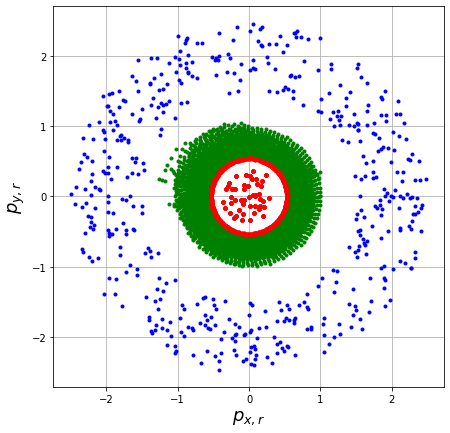

In [11]:
# Plot the training data in relative positions
fs = 18  # fontsize
px_rel_constr = x_constraint[:, 0] - x_constraint[:, 3]
py_rel_constr = x_constraint[:, 1] - x_constraint[:, 4]
px_rel_expert_unsafe = x_expert_unsafe[:, 0] - x_expert_unsafe[:, 3]
py_rel_expert_unsafe = x_expert_unsafe[:, 1] - x_expert_unsafe[:, 4]
px_rel_safe = x_safe[:, 0] - x_safe[:, 3]
py_rel_safe = x_safe[:, 1] - x_safe[:, 4]
px_rel_unsafe = x_unsafe[:, 0] - x_unsafe[:, 3]
py_rel_unsafe = x_unsafe[:, 1] - x_unsafe[:, 4]
plt.figure(figsize=(7, 7))
plt.plot(px_rel_constr / sf, py_rel_constr / sf, 'g.')
plt.plot(px_rel_safe / sf, py_rel_safe / sf, 'b.')
plt.plot(px_rel_expert_unsafe / sf, py_rel_expert_unsafe / sf, 'r.')
plt.plot(px_rel_unsafe / sf, py_rel_unsafe / sf, 'r.')
plt.xlabel('$p_{x,r}$', fontsize=fs)
plt.ylabel('$p_{y,r}$', fontsize=fs)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
# plt.xticks(np.arange(-2.5, 2.5+0.1, 0.5))
# plt.yticks(np.arange(-2.5, 2.5+0.1, 0.5))
# plt.xlim([-3, 3])
# plt.ylim([-3, 3])
# plt.axis('equal')
# plt.legend(['expert trajectories','safe samples','unsafe samples'], fontsize = fs)
plt.grid()
# plt.savefig('airplane_data.pdf', dpi=300)

In [ ]:
# Option 1: Load a trained CBF
if use_human_data:
  params = onp.load('params_human.npy', allow_pickle=True)
else:
  params = onp.load('params.npy', allow_pickle=True)

In [ ]:
# Option 2: Learn a CBF from expert demonstrations
rng = PRNG(5433)
start_time = time.time()
params = init_params
block_size = 1000
num_blocks = 50
num_epochs = block_size * num_blocks
num_batches = 1
safe_value = 1.5
unsafe_value = 0.5
lam_constraint = 15.0
lam_boundary = 1.0
lam_safe = 2.0
lam_unsafe = 2.0
lam_param = 0.1
gamma = 0.05

opt_init, opt_update, get_params = optimizers.adam(
    step_size=cosine_decay(0.1, num_epochs * num_batches)
)
opt_state = opt_init(init_params)
key = rng.next()

# training loop
for i in range(num_blocks):
  key, subkey = random.split(key)
  opt_state = tree_util.tree_map(
      lambda e: e.block_until_ready(),
      optimize_nn_with_input(
          key, num_batches, x_constraint, x_expert_unsafe, u_constraint, u_expert_unsafe, None,
          x_safe, x_unsafe, get_params, opt_update, opt_state, i * block_size, block_size,
          safe_value, unsafe_value, lam_constraint, lam_boundary, lam_safe, lam_unsafe, lam_param,
          gamma
      )
  )
  print(
      "epoch", (i+1) * block_size, "| loss",
      loss_with_input(
          x_constraint,
          x_expert_unsafe, u_constraint, u_expert_unsafe, None, safe_points, unsafe_points,
          get_params(opt_state), safe_value, unsafe_value, lam_constraint, lam_boundary, lam_safe,
          lam_unsafe, lam_param, gamma
      ), "| elapsed",
      time.time() - start_time, "seconds"
  )
params = get_params(opt_state)
# onp.save('params.npy', params)

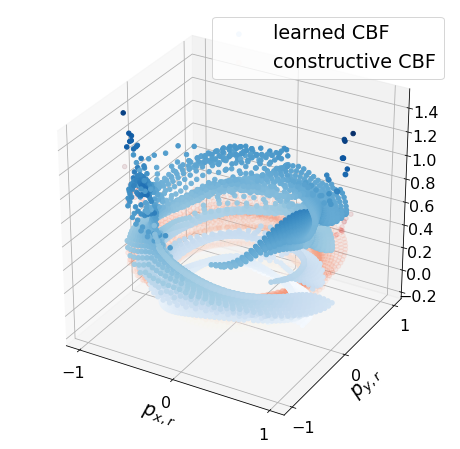

In [13]:
# Evaluate and plot the CBF at the training points
X_draw = X_train[:, :]
fs = 16  # fontsize
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
if use_human_data:
  rel_x_dist = X_draw[:, 0] / sf - X_draw[:, 3] / sf
  rel_y_dist = X_draw[:, 1] / sf - X_draw[:, 4] / sf
  hxl = onp.array([h_model(x, params) for x in X_draw])
  ax.scatter3D(rel_x_dist, rel_y_dist, hxl, c=hxl, cmap='Blues', alpha=1.0)
  plt.legend(['learned CBF'], fontsize=1.2 * fs)
  ax.set_xticks([-2, 0, 2])
  ax.set_yticks([-2, 0, 2])
  # ax.set_zticks([-1.0,0,1.0,2.0])
  ax.set_xlim([-2.1, 2.1])
  ax.set_ylim([-2.1, 2.1])
  # ax.set_zlim([-0.2, 0.8])
else:
  rel_x_dist = X_draw[:, 0] - X_draw[:, 3]
  rel_y_dist = X_draw[:, 1] - X_draw[:, 4]
  hxl = onp.array([h_model(x, params) for x in X_draw])
  ax.scatter3D(rel_x_dist, rel_y_dist, hxl, c=hxl, cmap='Blues', alpha=1.0)
  hx = onp.array([ZCBF(x) for x in X_draw])
  ax.scatter3D(rel_x_dist, rel_y_dist, hx, c=hx, cmap='Reds', alpha=0.1)
  plt.legend(['learned CBF', 'constructive CBF'], fontsize=1.2 * fs)
  ax.set_xticks([-1, 0, 1])
  ax.set_yticks([-1, 0, 1])
  # ax.set_zticks([-1.0,0,1.0,2.0])
  ax.set_xlim([-1.1, 1.1])
  ax.set_ylim([-1.1, 1.1])
  # ax.set_zlim([-0.2, 0.8])
plt.grid()
ax.set_xlabel('$p_{x,r}$', fontsize=1.2 * fs)
ax.set_ylabel('$p_{y,r}$', fontsize=1.2 * fs)
# ax.set_zlabel('$h(x)$',    fontsize = fs)
ax.xaxis.set_tick_params(labelsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.zaxis.set_tick_params(labelsize=fs)
# plt.axis('equal')
# plt.savefig('airplane_CBFs.pdf', dpi=300)

# Part 3: Safe Control with the Learned CBF

In [ ]:
# Safe closed-loop control with the learned CBF
if use_human_data:
  T = 20.
  N = 10
  ts = T / N
  u_lb = [0.3, -0.05, 0.3, -0.05]
  u_ub = [3.0, 0.05, 3.0, 0.05]
  Ds = 100
  X_start, X_goal = generate_init_condition(R=200.0, num_points=24)
else:
  X_start, X_goal = generate_init_condition(R=1.0, num_points=24)
X_cl_LCBF = []  # store the closed-loop trajectories
min_sep_set = []  # store the minimum separation between the two airplanes
idx_set = [17, 6, 21, 2, 4, 19, 0]  # the initial heading indices we used in our paper
for idx in idx_set:
  x_init = list(X_start[idx, :])
  x_goal = list(X_goal[idx, :])
  Xcl, Ucl, sep_min_cl = safe_closed_loop(
      x_init, x_goal, N_sim=100, learning=1, plot=1, early_stop=0
  )
  X_cl_LCBF.append(Xcl[:-1, :] / sf)
  min_sep_set.append(sep_min_cl / sf)


In [23]:
print('safe distance required:', Ds / sf)
print('minimal separations:', onp.float16(min_sep_set))

safe distance required: 0.5
minimal separations: [1.278  1.05   0.5757 0.579  0.85   0.999  0.5825]


<Figure size 432x288 with 0 Axes>

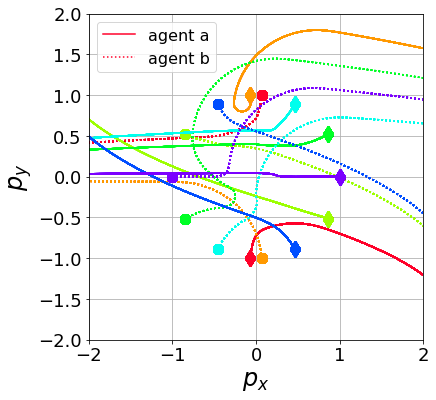

In [15]:
# Plot the closed-loop trajectories
def plot_closed_loop_multiple(X_cl_plot):
  fz = 20
  plt.clf()
  plt.figure(figsize=(6, 6))
  NUM_TRAJ = len(X_cl_plot)
  cm = plt.get_cmap('gist_rainbow')
  for i in range(NUM_TRAJ):
    Xcl = X_cl_plot[i,]
    for t in range(len(Xcl)):
      tgrid = [ts * k for k in range(t)]
      plt.plot(Xcl[:t, 0], Xcl[:t, 1], '-', color=cm(1. * i / NUM_TRAJ), linewidth=1.5)
      plt.plot(Xcl[:t, 3], Xcl[:t, 4], ':', color=cm(1. * i / NUM_TRAJ), linewidth=1.5)
      plt.plot(Xcl[0, 3], Xcl[0, 4], 'o', color=cm(1. * i / NUM_TRAJ), markersize=10)
      plt.plot(Xcl[0, 0], Xcl[0, 1], 'd', color=cm(1. * i / NUM_TRAJ), markersize=12)
  plt.xlabel('$p_x$', fontsize=1.2 * fz)
  plt.ylabel('$p_y$', fontsize=1.2 * fz)
  plt.rc('xtick', labelsize=fz)
  plt.rc('ytick', labelsize=fz)
  plt.legend(['agent a', 'agent b'], fontsize=0.8 * fz)
  # plt.xticks(np.arange(-2.5, 2.5+0.1, 0.5))
  # plt.yticks(np.arange(-2.0, 2.0+0.1, 0.5))
  plt.xlim([-2.0, 2.0])
  plt.ylim([-2.0, 2.0])
  # plt.axis('equal')
  plt.grid()
  # plt.savefig('airplane_traj.pdf', dpi=300)


plot_closed_loop_multiple(onp.array(X_cl_LCBF))